In [1]:
!pip3 uninstall -y MultibandMRI 
!pip3 install git+https://github.com/AdaptiveMRILab/MultibandMRI.git

Found existing installation: MultibandMRI 0.1.0
Uninstalling MultibandMRI-0.1.0:
  Successfully uninstalled MultibandMRI-0.1.0
  Cloning https://github.com/AdaptiveMRILab/MultibandMRI.git to /private/var/folders/30/x3_16p4d5j5cq5v20dn6smqm0000gq/T/pip-req-build-tzwge4tc
  Running command git clone --filter=blob:none --quiet https://github.com/AdaptiveMRILab/MultibandMRI.git /private/var/folders/30/x3_16p4d5j5cq5v20dn6smqm0000gq/T/pip-req-build-tzwge4tc
  Resolved https://github.com/AdaptiveMRILab/MultibandMRI.git to commit 6e00f11d64fdc49b7583674ce203949d2555e000
  Preparing metadata (setup.py) ... done
  Created wheel for MultibandMRI: filename=MultibandMRI-0.1.0-py3-none-any.whl size=4539 sha256=5075cb9eb5c8666ecd6b3713c73bfd17c9f3f64551aa3169ff9518ca82b88d21
  Stored in directory: /private/var/folders/30/x3_16p4d5j5cq5v20dn6smqm0000gq/T/pip-ephem-wheel-cache-b0ekqey9/wheels/54/cc/03/f5b8e399de4023fd079a1dbf0b918dbad6f0787e62b15802b9
Successfully built MultibandMRI


In [2]:
import torch 
import numpy as np 
import h5py 
import matplotlib.pyplot as plt 
from torch import Tensor
from MultibandMRI import slice_grappa 

device = torch.device('cpu')

In [8]:
from matrix_mri.recon import fft2d, ifft2d

contrast = 2

datapath = '/Users/nmickevicius/data/20250115_three_band_CMT/20250115_10_12_03_CMT_2D/_Series_0000/recon.h5'
with h5py.File(datapath,'r') as F:
    ksp = np.array(F['ksp'], dtype=np.complex64)[:,:,:,0,contrast]

aliased_datapath = '/Users/nmickevicius/data/20250115_three_band_CMT/20250115_10_19_18_CMT_2D/_Series_0000/recon.h5'
with h5py.File(aliased_datapath,'r') as F:
    aliased_ksp = np.array(F['ksp'], dtype=np.complex64)[:,:,:,0,contrast]
aliased_img = ifft2d(aliased_ksp, dims=(0,1)) 
aliased_rec = np.sqrt(np.sum(np.abs(aliased_img * aliased_img.conj()), axis=-1))
# plt.figure()
# plt.imshow(aliased_rec)
# plt.show()

img = ifft2d(ksp, dims=(0,1))
img = np.stack([img[:,:128,:], img[:,128:256,:],img[:,256:,:]], axis=-1)
data = fft2d(img, dims=(0,1))

# add CAIPI shifts to calibration data 
# data[:,1::3,:,0] = data[:,1::3,:,0] * np.exp(1j*2*np.pi/3)
# data[:,2::3,:,0] = data[:,2::3,:,0] * np.exp(1j*4*np.pi/3)
# data[:,1::3,:,2] = data[:,1::3,:,2] * np.exp(-1j*2*np.pi/3)
# data[:,2::3,:,2] = data[:,2::3,:,2] * np.exp(-1j*4*np.pi/3)

nacs = 32
i1 = int(data.shape[1]/2 - nacs/2)
i2 = i1 + nacs 
calib_data = data[:,i1:i2,...]

target = torch.tensor(calib_data.transpose(3,2,0,1), dtype=torch.complex64, device=device) 


# calibrate the kernels
sg = slice_grappa(target, accel=(1,1), kernel_size=(3,3), tik=0.0)


torch.Size([1, 32, 128, 32])
torch.Size([1, 1, 3780, 192])
torch.Size([3, 32, 1764, 1])


RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [96, 3780] but got: [96, 1764].

torch.Size([3, 32, 128, 128])
(128, 128, 3, 32)


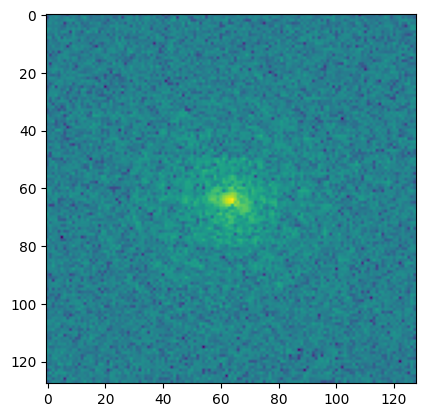

(128, 128, 3)


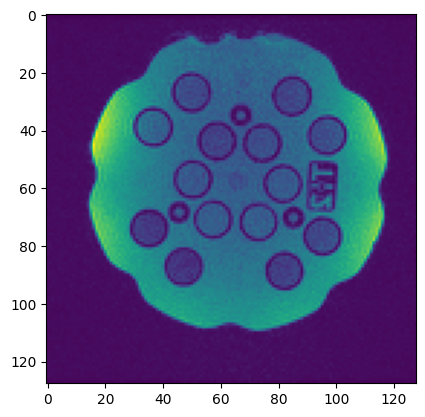

In [6]:
tmp = torch.tensor(data.transpose(3,2,0,1), dtype=torch.complex64, device=device) 
aliased_source = torch.sum(tmp, dim=0, keepdim=True)
# aliased_source[...,1::2] = 0.0

recon = sg.apply(aliased_source)
recon = recon.detach().cpu().numpy().transpose(2,3,0,1)

print(recon.shape) 
plt.figure()
plt.imshow(np.log10(np.abs(recon[:,:,0,0])))
plt.show()

recon = ifft2d(recon, dims=(0,1))
recon = np.sqrt(np.sum(np.abs(recon * recon.conj()), axis=-1))
print(recon.shape) 

plt.figure()
plt.imshow(recon[:,:,2])
plt.show()

In [5]:

kernel_size = 4
phase_accel = 2 

(kernel_size-1)*phase_accel // 2 - 1


2

torch.Size([1, 32, 128, 128])
(128, 256, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

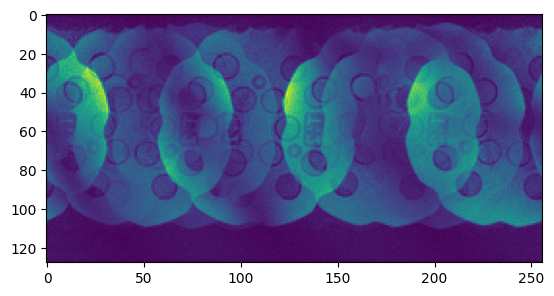

In [6]:
aliased_source = torch.tensor(aliased_ksp[None,...].transpose(0,3,1,2))

# in-plane acceleration 
aliased_source[...,1::2] = 0.0
print(aliased_source.shape)

recon = sg.apply(aliased_source)
recon = recon.detach().cpu().numpy().transpose(2,3,0,1)
recon = ifft2d(recon, dims=(0,1))
recon = np.sqrt(np.sum(np.abs(recon * recon.conj()), axis=-1))
print(recon.shape) 

# A_test = extract_and_flatten_multicoil_kspace_patches(aliased_source, kernel_size=kernel_size, pad=True)[:,None,:,:]
# print(A_test.shape)
# AX = A_test@X 
# AX = AX.view(3, 32, 128, 128)
# print(AX.shape)

# recon = AX.detach().cpu().numpy().transpose(2,3,0,1)
# recon = ifft2d(recon, dims=(0,1))
# recon = np.sqrt(np.sum(np.abs(recon * recon.conj()), axis=-1))
# print(recon.shape) 

plt.figure()
plt.imshow(recon[:,:,2])
plt.show

In [11]:
3//2

1